# Global mean Sea Surface Temperatures

In [1]:
import platform
import os

import numpy as np
import xarray as xr
import pandas as pd

from calendar import monthrange

from dask.distributed import Client
from dask import delayed
import dask

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

plt.rcParams['figure.figsize'] = (10, 4)

In [2]:
# Define a transformation to ensure the polygon's CRS matches
# Transform the polygon to match the DataArray CRS if needed
def transform_polygon(polygon, src_crs='epsg:4326', tgt_crs='epsg:4326'):
    proj = pyproj.Transformer.from_proj(pyproj.Proj(src_crs), pyproj.Proj(tgt_crs), always_xy=True)
    return transform(lambda x, y: proj.transform(x, y), polygon)

In [3]:
def point_in_polygon(lon, lat, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

# Settings

# Inicio

In [4]:
HOME=os.environ['HOME']   
f = open(HOME+'/.env', 'r')
for line in f.readlines():
    Name=line.strip().split('=')[0]
    Content=line.strip().split('=')[-1]
    if Name=='dirData' or Name=='dirAnalisis':
        exec(Name + "=" + "'" + Content + "'")
f.close()

In [5]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = dirData + '/Satelite/MUR/NC/'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('sagams') != -1:
    base_file = dirData + '/Satelite/MUR/NC/'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = dirData + '/Satelite/MUR/NC/'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'

In [6]:
base_file

'/data/pvb/Satelite/MUR/NC/'

## Load data

In [7]:
year1= 2003
year2= 2013
files = []
for iy in range(year1,year2+1):
    for im in range(1,13):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [8]:
DS = xr.open_mfdataset(files)

In [9]:
year1= 2014
year2= 2019
files = []
for iy in range(year1,year2+1):
    for im in range(1,13):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [10]:
DS2 = xr.open_mfdataset(files)

/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/ocean/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(
/opt/conda/envs/ocean/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(
/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning,

: 

In [ ]:
sst=xr.concat(DS.analysed_sst.sel(lat=29,lon=-15),DS2.analysed_sst.sel(lat=29,lon=-15), dim="time")
Out[4]: 

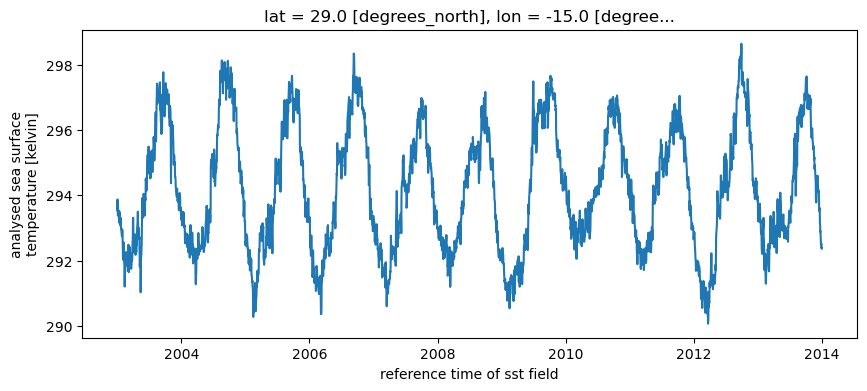

In [ ]:
DS.analysed_sst.sel(lat=29,lon=-15).plot()

In [19]:
print('>>>>> Daily'+titulo+titulo_short)

>>>>> DailyDemarcación marina levantino-balearLEB


In [21]:
## Calculate mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)


In [22]:
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

In [23]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').load();

In [24]:
## Create anomaly
sst_anom = sst.groupby('time.dayofyear') - sst_clim

/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]


In [25]:
## Calculate global mean anomaly
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()

In [69]:
## Save in netcdf
sst_wmean.to_netcdf(dataDir+'/sstd_mean_'+titulo_short+'.nc',mode='w')   
sst_anom_wmean.to_netcdf(dataDir+'/sstd_anom_mean_'+titulo_short+'.nc',mode='w')

In [70]:
if titulo_short=='GO' or titulo_short=='NAtl' or titulo_short=='LEB' or titulo_short=='CAN' or titulo_short=='NOR' or titulo_short=='SUD' or titulo_short=='ESA' or titulo_short=='IBICan':
        sst_anom_LD=sst_anom[-1,:,:]
        sst_anom_LD.to_netcdf(dataDir+'/sstLD_anom_'+titulo_short+'.nc',mode='w')

# Monthly analisis

In [26]:
sst = sst.resample(time='ME').mean(dim='time',skipna=True).load()

In [27]:
## Calculate global mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()
    

In [28]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

In [29]:
## Create anomaly
print('    > Compute anomaly mean')
sst_anom = sst.groupby('time.month') - sst_clim
sst_anom.load();

    > Compute anomaly mean


In [30]:
##Calculate global mean weigthtened
print('    > Compute weigthtened mean')
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=12,center=True).mean()

    > Compute weigthtened mean


In [ ]:
##Save in netcdf
print('    > to netcdf')
sst_anom.to_netcdf(dataDir+'/sstm_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir+'/sstm_mean_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir+'/sstm_anom_mean_'+titulo_short+'.nc',mode='w')

In [ ]:

monthrange(2011, 2)[1]

28